# MNIST Dataset with Softmax

In this notebook, we will demonstrate how to use the JLNN to build a simple Multi-layer Perceptron to classify the MNIST dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [1]:
# Pkg.update()
# Pkg.add("MNIST")

# Pkg.add("PyPlot")
using PyPlot

In [2]:
include("layers/SoftMaxCrossEntropy.jl")
include("layers/SquareLossLayer.jl")
include("layers/FCLayer.jl")
include("layers/DropoutLayer.jl")
include("layers/ReLu.jl")
include("layers/Tanh.jl")
include("layers/SequnetialNet.jl")

[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


backward (generic function with 7 methods)

# Data Preparation

In this section, we will prepare the MNIST dataset to train the classifier. MNIST dataset contains 60000 grey-scale images, each of which has dimensions 28x28. We will flatten these data so that each image will become a vector of 784 dimensions, and the label will be between 0 and 9.

We also split the data into training, validation and testing sets. The corresponding ratio of those data sets are 80%, 10% and 10%.

In [3]:
using MNIST
function mnistData(ttl=55000)
    features = trainfeatures(1)
    label = trainlabel(1)

    trainX, trainY = traindata()
    N = size(trainX)[2]
    idx = randperm(N)
    trainX = trainX[:, idx]'
    trainY = trainY[idx]

    testX, testY = testdata()
    N = size(testX)[1]
    idx = randperm(N)
    testX = testX[:, idx]'
    testY = testY[idx]
    
    X, Y = trainX[1:ttl,:], trainY[1:ttl,:]

    @assert size(X)[1] == size(Y)[1]
    # println(size(trX), size(trY))
    
    # Tiny bit of preprocessing, the image will be put in range of 0..1
    X = X / 256. 
    return X, Y
end
X, Y = mnistData()
size(X), size(Y)

((55000,784),(55000,1))

In [4]:
function datasplit(trX, trY)
    local N = size(trY)[1]
    local size_training = convert(Int, N * 8/10)
    local size_testing = convert(Int, N / 10)
    local train_set = (trX[1:size_training,:],trY[1:size_training,:])
    local test_set = (trX[size_training + 1:size_training + size_testing, :], 
                                trY[size_training + 1 : size_training + size_testing, :])
    local validation_set =  (trX[size_training + size_testing + 1:N, :], 
                                    trY[size_training + size_testing + 1:N,:])
    return train_set, test_set, validation_set
end

train_set, test_set, validation_set = datasplit(X, Y)
trX, trY   = train_set
valX, valY = validation_set
teX, teY   = test_set
size(trX),size(trY),size(valX),size(valY),size(teX),size(teY)

((44000,784),(44000,1),(5500,784),(5500,1),(5500,784),(5500,1))

# Network Structure

We use a really really simple network structure that contains a single Dense Layer and a softmax cross entropy loss. The output of the classifier is defined as:

$$y = softmax(Wx+b)$$
where function $softmax(v)$ is defined as:

$$softmax(x)_i = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

The loss function adapted the cross entropy function (which is a special case for KL-Divergence, when $p$, the ground truth probability is set to a hot vector):

$$\mathcal{L}=-\sum_{i}p_i\log{y_i}$$

The way to defined such classifier in JLNN is really simple:

In [5]:
function softmax_clf()
    layers = Layer[ FCLayer(784, 10) ]
    criteria = SoftMaxCrossEntropyLoss()
    net = SequentialNet(layers, criteria)
    return net
end
net = softmax_clf()

SequentialNet(Layer[FCLayer(784,[0.120388 -0.19737 … -0.146805 -0.537739; 0.224876 -0.482992 … -0.0447933 -0.381154; … ; -0.216973 -0.0540683 … 0.035106 -0.123465; 0.0 0.0 … 0.0 0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])],SoftMaxCrossEntropyLoss(Float64[],Float64[],#undef))

# Training and Optimizations

In this section, we train our network to learn the MNIST dataset. The network is consist of one FC layer, one cross-Entropy with soft max layer, and one sequential net. The training function we choose is the simple stochastic gradient descent.

In [6]:
function get_corr(pred, answ)
    return length(filter(e -> abs(e) < 1e-5, pred-answ))
end
function train(net::SequentialNet, X, Y; 
    batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), verbose=0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local epo_accus = []
    local val_losses = []
    local val_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        all_losses = []
        epo_cor = 0
        for bid = 0:(num_batch-1)
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, _ = forward(net, batch_X, batch_Y)
            backward(net, batch_Y)
            append!(all_losses, mean(loss))
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * gradient(layer) / batch_size
                local theta = getParam(layer) - gradi
                if verbose > 2
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end

            _, pred = forward(net, batch_X, batch_Y; deterministics = true)
            epo_cor  += length(filter(e ->  abs(e) < 1e-5, pred - batch_Y))
            local acc = length(filter(e -> abs(e) < 1e-5, pred - batch_Y)) / batch_size
            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(epo_losses, epo_loss)
        append!(epo_accus, epo_accu)
        v_loss, v_pred = forward(net, valX, valY)
        v_size = size(valX)[1]
        v_accu = get_corr(v_pred, valY) / v_size
        append!(val_losses, mean(v_loss))
        append!(val_accu,   v_accu)
        if epo % 10 == 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
            println("Validation accuracy : $(v_accu)")
        end
        if verbose > 0
            println("Epo $(epo) has loss :$(mean(epo_loss))\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses,epo_accus,val_losses,val_accu
end

train (generic function with 1 method)

Epo 10 has loss :0.46458139878615523		accuracy : 0.8645681818181818
Validation accuracy : 0.8663636363636363
Epo 20 has loss :0.3896550437078697		accuracy : 0.8881363636363636
Validation accuracy : 0.8847272727272727
Epo 30 has loss :0.3591292030397338		accuracy : 0.8972045454545454
Validation accuracy : 0.895090909090909
Epo 40 has loss :0.34132056495233465		accuracy : 0.9024318181818182
Validation accuracy : 0.9012727272727272
Epo 50 has loss :0.32922374396929527		accuracy : 0.9058181818181819
Validation accuracy : 0.9043636363636364
Epo 60 has loss :0.32027932848592017		accuracy : 0.9087954545454545
Validation accuracy : 0.9065454545454545
Epo 70 has loss :0.3132956007477259		accuracy : 0.91125
Validation accuracy : 0.9085454545454545
Epo 80 has loss :0.30763074566113163		accuracy : 0.9132045454545454
Validation accuracy : 0.9105454545454545
Epo 90 has loss :0.3029039380033865		accuracy : 0.9148181818181819
Validation accuracy : 0.9107272727272727
Epo 100 has loss :0.298872993451401

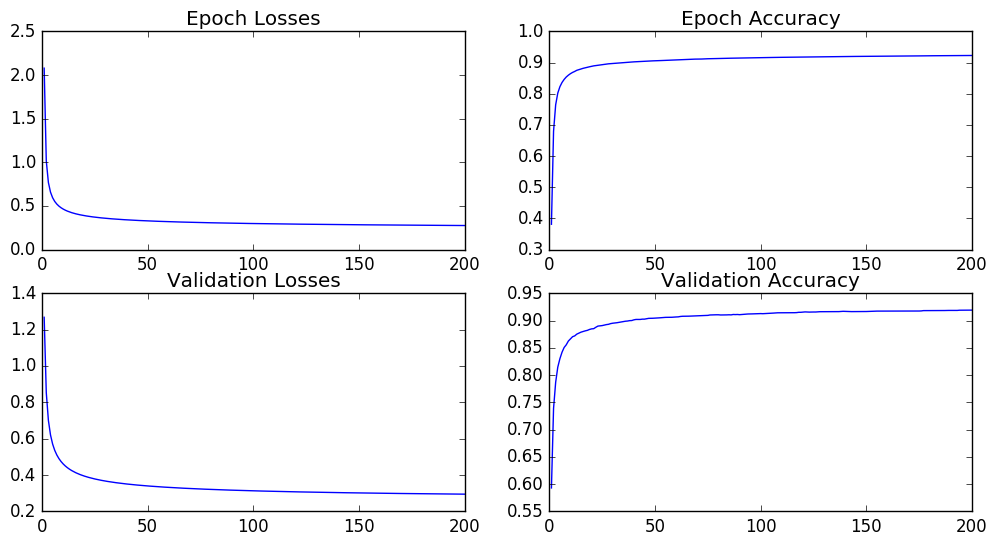

Epo 200 has loss :0.27614207114519485		accuracy : 0.9228636363636363
Validation accuracy : 0.9190909090909091


In [7]:
net = softmax_clf()

losses,accus,val_losses,val_accus = train(net, trX, trY;
    ttl_epo = 200, batch_size = 100, lrSchedule = x -> 0.01, verbose=0)

figure(figsize=(12,6))
subplot(221)
plot(1:length(losses), losses)
title("Epoch Losses")

subplot(222)
plot(1:length(accus), accus)
title("Epoch Accuracy")
show()

subplot(223)
plot(1: length(val_losses), val_losses)
title("Validation Losses")
show()

subplot(224)
plot(1: length(val_accus), val_accus)
title("Validation Accuracy")
show()


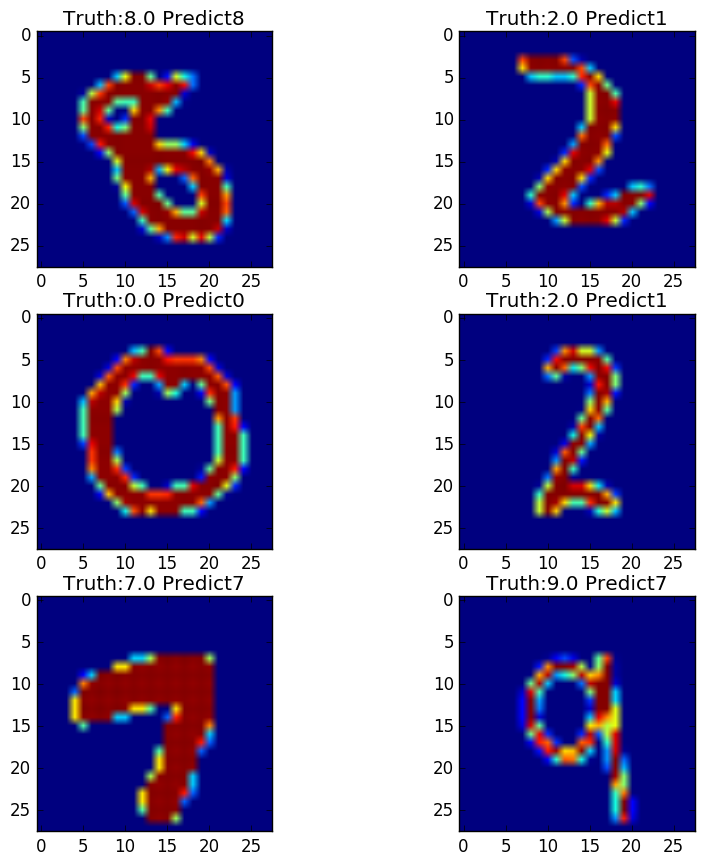

Testing Accuracy:0.9165454545454546


In [11]:
_, pred = forward(net, teX, teY; deterministics = true)
N = size(teX)[1]
corr = length(filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N))
right_idx = filter(i-> abs(pred[i] - teY[i]) <  1e-5, 1:N)[1:3]
wrong_idx = filter(i-> abs(pred[i] - teY[i]) >= 1e-5, 1:N)[1:3]

println("Testing Accuracy:$(corr/N)")

figure(figsize=(10,10))
subplot(321)
imshow(reshape(teX[right_idx[1],:], 28,28))
title("Truth:$(teY[right_idx[1]]) Predict$(pred[right_idx[1]])")

subplot(322)
imshow(reshape(teX[wrong_idx[1],:], 28,28))
title("Truth:$(teY[wrong_idx[1]]) Predict$(pred[wrong_idx[1]])")

subplot(323)
imshow(reshape(teX[right_idx[2],:], 28,28))
title("Truth:$(teY[right_idx[2]]) Predict$(pred[right_idx[2]])")

subplot(324)
imshow(reshape(teX[wrong_idx[2],:], 28,28))
title("Truth:$(teY[wrong_idx[2]]) Predict$(pred[wrong_idx[2]])")

subplot(325)
imshow(reshape(teX[right_idx[3],:], 28,28))
title("Truth:$(teY[right_idx[3]]) Predict$(pred[right_idx[3]])")

subplot(326)
imshow(reshape(teX[wrong_idx[3],:], 28,28))
title("Truth:$(teY[wrong_idx[3]]) Predict$(pred[wrong_idx[3]])")
show()